In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

/usr/local/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Data

전화로 설문조사한 고객이 정기 예금에 가입할 것인지( 가입하면 1, 가입 안하면 0 ) 예측하는 문제. 
전형적인 classification 문제이다.

41188개의 데이터, 21개 feature

In [2]:
data = pd.read_csv('bank.csv', header=0)
data = data.dropna()
print(data.shape)
print(list(data.columns))

(41188, 21)
['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y']


In [3]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


#### 고객 데이터의 변수들은 다음과 같다.

1 - age (numeric) : 나이

2 - job : 직업의 종류 (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : 결혼 상태 (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education : 교육 수준(categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: 파산했는지 여부 (categorical: 'no','yes','unknown')

6 - housing: 주택 대출이 있는지 여부 (categorical: 'no','yes','unknown')

7 - loan: 개인 대출 있는지 여부 (categorical: 'no','yes','unknown')

8 - contact: 핸드폰, 전화기 (categorical: 'cellular','telephone')

9 - month: 마지막 연락한 달 (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10 - day_of_week: 마지막 연락한 요일 (categorical: 'mon','tue','wed','thu','fri')

11 - duration: 통화 지속 시간 (numeric). 

12 - campaign: 통화한 횟수 (numeric, includes last contact)

13 - pdays: 고객이 이전 광고주와 연락하고 지난 시간 (numeric; 999 means client was not previously contacted)

14 - previous: 이번 전화 전에 통화한 횟수 (numeric)

15 - poutcome: 이전 설문조사의 결과 (categorical: 'failure','nonexistent','success')

16 - emp.var.rate: employment variation rate - (numeric)

17 - cons.price.idx: 고객 가격 지수 - (numeric)

18 - cons.conf.idx: 고객 신뢰 지수 - (numeric) 

19 - euribor3m: euribor 3 개월 지수?? - (numeric)

20 - nr.employed: 직원 수 - (numeric)

education 의 feature 종류가 너무 세분화되어 있어서 묶어 줄 필요가 있었습니다.

In [4]:
data['education'].unique()

array(['basic.4y', 'unknown', 'university.degree', 'high.school',
       'basic.9y', 'professional.course', 'basic.6y', 'illiterate'],
      dtype=object)

basic 어쩌구는 다 basic 으로 묶어주었습니다.

In [5]:
data['education']=np.where(data['education'] =='basic.9y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.6y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.4y', 'Basic', data['education'])

In [6]:
data['education'].unique()

array(['Basic', 'unknown', 'university.degree', 'high.school',
       'professional.course', 'illiterate'], dtype=object)

# 1. 데이터 조사하기 ; 눈으로 보고 의미 있는 feature 찾아내기
본격적인 첫 번째 단계는 직접 feature 를 보면서 어떤게 의미있을지 사람이 추측하는 방법입니다. 이 부분에서 데이터 분석 경험이 많이 필요할 듯 합니다.

In [7]:
data['y'].value_counts()

0    36548
1     4640
Name: y, dtype: int64

### 데이터 살펴보는 방법 1 : mean() 함수를 이용해서 특정 feature 를 기준으로 다른 변수들의 평균을 보면서 의미를 살펴보기.

In [8]:
data.groupby('y').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
y,,,,,,,,,,
0,39.911185,220.844807,2.633085,984.113878,0.132374,0.248875,93.603757,-40.593097,3.811491,5176.166600
1,40.913147,553.191164,2.051724,792.035560,0.492672,-1.233448,93.354386,-39.789784,2.123135,5095.115991


- age : 정기예금에 가입한 고객은 그렇지 않은 고객보다 나이가 많다.
- pdays : 정기예금에 가입한 고객은 그렇지 않은 고객보다 마지막으로 연락한 날이 짧다.

### 방법2 : feature 별로 시각화 해서 의미 있는지 살펴보기

#### 1. 직업

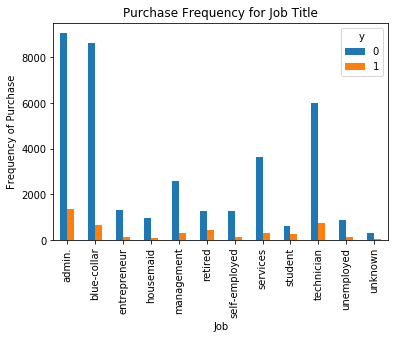

In [9]:
%matplotlib inline
pd.crosstab(data.job,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchase')
plt.savefig('purchase_fre_job')

admin,blue-collar,technician 가 특히 구입횟수가 높은걸 볼때 의미가 있을 것이다.

#### 2. 결혼여부

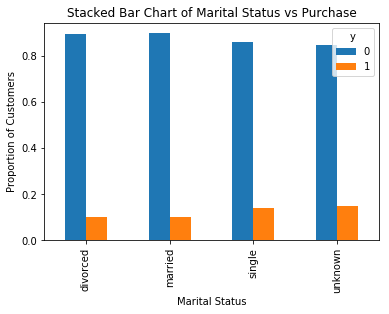

In [10]:
table=pd.crosstab(data.marital,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar')
plt.title('Stacked Bar Chart of Marital Status vs Purchase')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers')
plt.savefig('mariral_vs_pur_stack')

결혼 여부는 별로 차이가 없는 거 봐서 의미가 없을 듯.

#### 3. 교육 수준

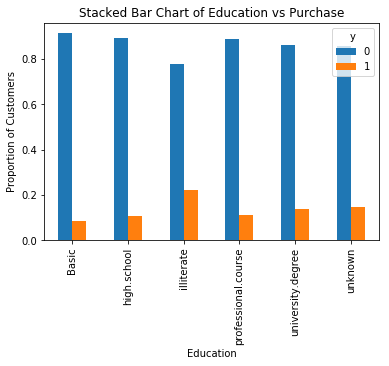

In [11]:
table=pd.crosstab(data.education,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar')
plt.title('Stacked Bar Chart of Education vs Purchase')
plt.xlabel('Education')
plt.ylabel('Proportion of Customers')
plt.savefig('edu_vs_pur_stack')

글을 모르는 자(illeterate) 가 많이 가입하는 비중이 있는 걸로 봐서 의미가 있을 듯 하다.

#### 요일

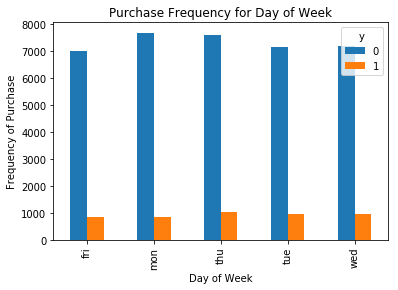

In [12]:
pd.crosstab(data.day_of_week,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_dayofweek_bar')

요일은 다 비슷비슷한 게 필요 없을 듯 하다.

#### 달

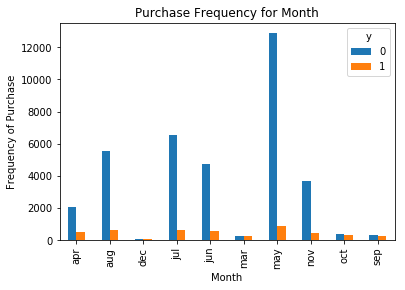

In [13]:
pd.crosstab(data.month,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Month')
plt.xlabel('Month')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_fre_month_bar')

월별로 1의 빈도가 달라서 의미가 있을 듯 하다.

#### 나이

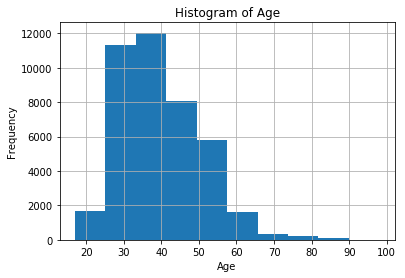

In [14]:
data.age.hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.savefig('hist_age')

대부분이 3~40대인거 봐서 의미 있을 듯

#### 마케팅의 성공여부

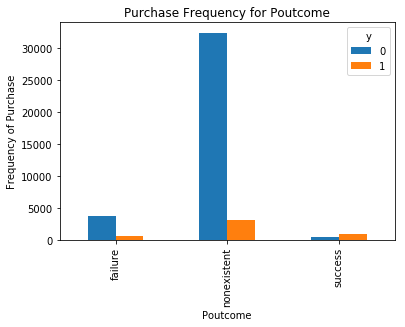

In [15]:
pd.crosstab(data.poutcome,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Poutcome')
plt.xlabel('Poutcome')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_fre_pout_bar')

nonexistent 가 튀는 걸로 봐서 의미가 있을 듯 함.

# 2. 더미변수 만들기
명목척도들을 더미변수로 만들어준다. 명목척도, 즉 경우의 수가 분류되는 변수는 이렇게 더미변수로 만들어줘야 한다.

In [16]:
cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
for var in cat_vars:
    cat_list='var'+'_'+ var
    # 더미변수 생성 함수. get_dummies(만들고 싶은 컬럼, 더미변수 앞에 붙일 값)
    cat_list = pd.get_dummies(data[var], prefix=var)
    data1=data.join(cat_list)
    data=data1

In [17]:
# 더미변수 처리해 준거 다 지우기.
cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
print(to_keep)

['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'education_Basic', 'education_high.school', 'education_illiterate', 'education_professional.course', 'education_university.degree', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'poutcome_failure', 'poutco

In [18]:
data_final=data[to_keep]
data_final.columns.values

array(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_Basic', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_no',
       'default_unknown', 'default_yes', 'housing_no', 'housing_unknown',
       'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes',
       'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri',

In [19]:
# 최종 x,y
data_final_vars=data_final.columns.values.tolist()
y=['y']
X=[i for i in data_final_vars if i not in y]

# Feature 선택
위에서 우리가 눈으로 데이터를 하나씩 확인해 가면서 중요한 것 , 중요하지 않은 것에 대해 생각했습니다.
하지만 그렇게 직접 구별해서 따로 feature 를 지워주지 않고, 중요하지 않은 feature를 걸러내는 알고리즘을 사용해서 걸러냈습니다.
(이 부분 원래 이렇게 하는건지 저 좀 알려주세요 ㅠ.ㅠ)
그 방식에는 몇가지가 있는데 , 
http://otzslayer.github.io/machine-learning/feature-selection/
를 꼭 확인 바랍니다.

여기서 선택한 RFE는 재귀적으로 feature를 선택해 가면서 정확도가 낮을 때의 변수를 알려주는 방식입니다.


In [20]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

rfe = RFE(logreg, 18)
rfe = rfe.fit(data_final[X], data_final[y] )
print(rfe.support_)
print(rfe.ranking_)

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[False False False False  True False False False  True False False  True
 False False False  True False  True  True False False False False False
 False False  True False False False False False  True False False False
 False False False False False False  True  True  True False False False
  True  True  True False False False  True False False False  True  True
  True]
[42 34 11 36  1 15 17 16  1 29 10  1 22 40 25  1 33  1  1 18 19 38 39 14
 13 41  1  2 37  3  4  5  1 12 44 20 32 31 21 28 30  7  1  1  1 24 27 23
  1  1  1 43  8  9  1 35 26  6  1  1  1]


위에서 True 로 나온 feature 들이 의미가 있는 feature 들이므로 최종적으로 이것들만 남겨주면 됩니다.

In [21]:
cols=["previous", "euribor3m", "job_blue-collar", "job_retired", "job_services", "job_student", "default_no", 
      "month_aug", "month_dec", "month_jul", "month_nov", "month_oct", "month_sep", "day_of_week_fri", "day_of_week_wed", 
      "poutcome_failure", "poutcome_nonexistent", "poutcome_success"] 
X=data_final[cols]
y=data_final['y']

## 전처리가 끝났고, 이제 모델을 돌려볼 차례입니다.
모델 돌리는건 굉장히 허무합니다. 그냥 앞에서 설명한 이론이 구현되어 있는 함수에 우리가 전처리한 데이터를 넣어주면 됩니다.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [23]:
y_pred = logreg.predict(X_test)

In [24]:
print('우리 모델을 테스트셋에 테스트했을 때 정답률: {:.2f}'.format(logreg.score(X_test, y_test)))

우리 모델을 테스트셋에 테스트했을 때 정답률: 0.90


## 검증

### 1. Cross Validation
참고자료 : https://datascienceschool.net/view-notebook/266d699d748847b3a3aa7b9805b846ae/
데이터를 학습 /검증 용도로 분리할 때 어떻게 분리하느냐에 따라서 결과가 다르게 나올 수 있기 때문에, k개로 나눈 다음에 각각 검증 데이터를 다르게 해서 그 평균값을 계산하는 방법입니다.

In [25]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = LogisticRegression()
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

10-fold cross validation average accuracy: 0.897


### 2. Confusion Matrix
https://m.blog.naver.com/kmkim1222/220106232149
성능 평가에 많이 사용되는 Matrix 입니다.
예측 한 것과 실제 값을 비교합니다. 

In [26]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[10872   109]
 [ 1122   254]]


10872+254 개를 맞추고 1122+109 개가 틀렸습니다.

위 matrix에서 pricision,matrix 등이 파생됩니다.

### 3. F1-Score
precision과 recall 의 조화 평균입니다.

In [27]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.91      0.99      0.95     10981
          1       0.70      0.18      0.29      1376

avg / total       0.88      0.90      0.87     12357



precision(True로 예측한 값 중 진짜 True) : 88% 

recall(진짜 True 중 True로 맞게 예측한 값) : 90%